<!-- ![pose image](https://miro.medium.com/v2/resize:fit:772/1*JJCbfzhTySIqKr1L5pDkpQ.png)
![hand image](https://www.researchgate.net/publication/374146815/figure/fig1/AS:11431281190974773@1695558751504/sualization-of-Mediapipe-hand-landmark-locations-based-on-hand-joints-Labels-1-4-are.png) -->

In [2]:
import mediapipe as mp
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import time
import tkinter as tk
from tkinter.ttk import *
import threading
from PIL import Image, ImageTk
import ipywidgets as widgets
from IPython.display import display
import pytz
from datetime import datetime
import pygame

from tkinter import filedialog

pygame 2.6.1 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
mp_drawing = mp.solutions.drawing_utils

# mp_hands = mp.solutions.hands
# hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)

mp_pose=mp.solutions.pose
pose=mp_pose.Pose(model_complexity=0, min_detection_confidence=0.5, min_tracking_confidence=0.5)

pose_results=None
frame_rgb=None

def process_frame(frame):
    global pose_results, frame_rgb
    # Process the frame with MediaPipe Pose
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert frame to RGB for MediaPipe
    frame_rgb.flags.writeable = False
    pose_results = pose.process(frame_rgb)  # Pose processing
    frame_rgb.flags.writeable = True

landmark_drawing_spec = mp_drawing.DrawingSpec(color=(255, 100, 100), thickness=2, circle_radius=2)
connection_drawing_spec = mp_drawing.DrawingSpec(color=(180, 40, 252), thickness=2, circle_radius=2)

In [4]:
specific_landmark_indices = [11, 12, 13, 14, 15, 16, 21, 22]  

specific_connections = [
    (11,12),
    (11,13),
    (13,15),
    (12,14),
    (14,16),
    (16,22),
    (15,21),
]

def draw_specific_landmarks(image, landmarks, landmark_indices, connections, landmark_style, connection_style):
    h, w, _ = image.shape
    for idx in landmark_indices:
        landmark = landmarks.landmark[idx]
        cx, cy = int(landmark.x * w), int(landmark.y * h)
        cv2.circle(image, (cx, cy), landmark_style.circle_radius, landmark_style.color, landmark_style.thickness)
    
    for connection in connections:
        start_idx, end_idx = connection
        start_landmark = landmarks.landmark[start_idx]
        end_landmark = landmarks.landmark[end_idx]
        start_cx, start_cy = int(start_landmark.x * w), int(start_landmark.y * h)
        end_cx, end_cy = int(end_landmark.x * w), int(end_landmark.y * h)
        cv2.line(image, (start_cx, start_cy), (end_cx, end_cy), connection_style.color, connection_style.thickness)

Text(0.5, 1.0, 'Right Hand Movement')

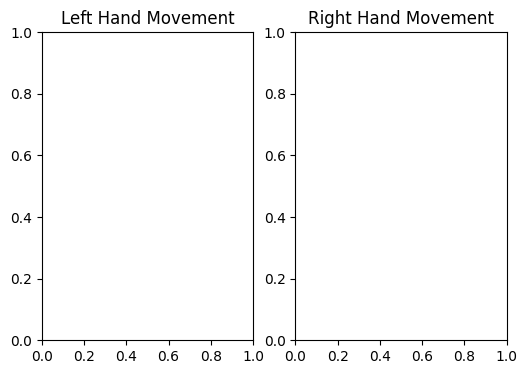

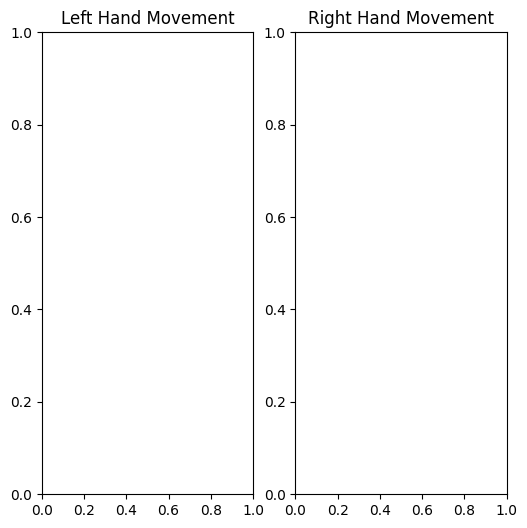

In [5]:
#graphing details

#screen 2
fig, (ax_left, ax_right) = plt.subplots(1,2, figsize=(6,4))
for ax in [ax_left, ax_right]:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# Create empty lines for updating the plots
left_line, = ax_left.plot([], [], 'ro-', markersize=5)  # Red for left
right_line, = ax_right.plot([], [], 'bo-', markersize=5)  # Blue for right

ax_left.set_title('Left Hand Movement')
ax_right.set_title('Right Hand Movement')

left_data_x, left_data_y = [], []
right_data_x, right_data_y = [], []

#screen 3
analysis_fig, (analysis_left, analysis_right) = plt.subplots(1, 2, figsize=(6, 6))
for ax in [analysis_left, analysis_right]:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# Create empty scatter plots for updating the plots
left_scatter = analysis_left.scatter([], [])  # Red for left
right_scatter = analysis_right.scatter([], [])  # Blue for right

analysis_left.set_title('Left Hand Movement')
analysis_right.set_title('Right Hand Movement')


In [6]:
#determining pattern method

def determining_pattern(determine_pattern):
    match determine_pattern:
        case ['up1']:
            return '1/4'
        case ['out', 'up1']:
            return '2/4'
        case['up2', 'out', 'up1']:
            return '3/4'
        case['up2','in', 'out', 'up1']:
            return '4/4'
        case _:
            return 'NA'

In [7]:
#get time function
def get_time(time_stamps):
    #take time bw each--> calculate bpm between each beat--> average out the bpm
    time_bpms=[]
    for index, value in reversed(list(enumerate(time_stamps))):
        if index>0:
            time_bpms.append(60/(time_stamps[index]-time_stamps[index-1]))

    if len(time_bpms)!=0:
        return round(np.mean(time_bpms))
    



In [8]:
#Determining conducting patterns
beats=0
type='NA'
pattern='NA'

Prep_Started=False

determine_pattern=[]

global_max_y=0.7
new_global_max_y=[]

left_min_x, left_max_x, left_max_y=1, 0, 0
right_min_x, right_max_x, right_max_y=1, 0, 0

left_basis, right_basis=0,0

#add timestamps to array--> if pattern is found--> calculating tempo based off timestamps/size of array
time_stamps=[]
current_tempo=-1


def method_1(left_data_y, right_data_y, graphing_data_points):
    #ictus is [-2]--> currently adding to [0]--> too late
    global  beats, left_min_x, left_max_x, left_max_y, right_min_x, right_max_x, right_max_y, pattern, left_basis, right_basis, global_max_y, new_global_max_y, type, determine_pattern, Prep_Started, time_stamps, current_tempo
    
    if len(left_data_y)>=3 and len(right_data_y)>=3:
        average_left_movement=np.mean([left_data_y[-1]-left_data_y[-2], left_data_y[-3]-left_data_y[-2]])
        average_right_movement=np.mean([right_data_y[-1]-right_data_y[-2], right_data_y[-3]-right_data_y[-2]])
        
        if (((left_data_y[-2]<left_data_y[-1] and left_data_y[-2]<left_data_y[-3]) and (right_data_y[-2]<right_data_y[-1] and right_data_y[-2]<right_data_y[-3]))) and (np.mean([average_left_movement, average_right_movement])>.025):
            beats+=1
            
            graphing_data_points["left_ictus"].append((left_data_x[-2], left_data_y[-2]))
            graphing_data_points["right_ictus"].append((right_data_x[-2], right_data_y[-2]))
            
            
            if not Prep_Started:
                beats-=1
                Prep_Started=True

            #since all ahve up1--> use that as a basis--> each up1 creates new basis/reset

            if abs(left_min_x - left_max_x) < 0.1 and abs(right_min_x - right_max_x) < 0.1:
                #up1
                if (left_max_y+right_max_y)/2>0.9*global_max_y:
                    type='up1'
                    
                    left_basis=(left_max_x+left_min_x)/2
                    right_basis=(right_max_x+right_min_x)/2

                    graphing_data_points["left_up1"].append((left_basis, left_max_y))
                    graphing_data_points["right_up1"].append((right_basis, right_max_y))
                    
                    if len(new_global_max_y)==3:
                        global_max_y=np.mean(new_global_max_y)
                        new_global_max_y=[]
                    else:
                        new_global_max_y.append((left_max_y+right_max_y)/2)

                    
                    time_stamps.append(time.time())
                    determine_pattern.append('up1')
                    pattern=determining_pattern(determine_pattern)
                    determine_pattern.clear()
                    
                    if pattern!='NA':
                        current_tempo=get_time(time_stamps)
                        time_stamps.clear()
                    
                    

                #up2
                else:
                    type='up2'
                    graphing_data_points["left_up2"].append((left_basis, left_max_y))
                    graphing_data_points["right_up2"].append((right_basis, right_max_y))
                    time_stamps.append(time.time())
                    determine_pattern.append('up2')
            else:
                #in--> Lmax much greater than up1, Lmin relatively same, Rmin much less than up1, Rmax relatively same
                if left_max_x-left_basis>.025 and abs(left_min_x-left_basis)<.1 and right_basis-right_min_x>.025 and abs(right_max_x-right_basis)<.1:
                    type='in'
                    time_stamps.append(time.time())
                    determine_pattern.append('in')
                    
                    graphing_data_points["left_in"].append((left_max_x, left_max_y))
                    graphing_data_points["right_in"].append((right_min_x, right_max_y))
                    
                #out--> Lmin should be much less than up1, Lmax relatively same, Rmin relatively same, Rmax much greater
                elif left_basis-left_min_x>.025 and abs(left_max_x-left_basis)<.1 and right_max_x-right_basis>.025 and abs(right_min_x-right_basis)<.1:
                    type='out'
                    time_stamps.append(time.time())
                    determine_pattern.append('out')
                    graphing_data_points["left_out"].append((left_min_x, left_max_y))
                    graphing_data_points["right_out"].append((right_max_x, right_max_y))
                    
                    
                #Cannot confidently determine
                else:
                    type='NA'
                    time_stamps.append(time.time())
                    determine_pattern.append('NA')

            if len(determine_pattern)>4:
                pattern='NA'
                current_tempo=-1
                time_stamps.clear()
                determine_pattern.clear()

        
            
            
            
            # print(f"{pattern}--{left_basis}--{right_basis}--{left_min_x}--{left_max_x}--{right_min_x}--{right_max_x}")
            left_min_x, left_max_x, left_max_y=1, 0, 0
            right_min_x, right_max_x, right_max_y=1, 0, 0

In [9]:
#loading images, time function

def load_image(path, size):
    image = Image.open(path)
    image = image.resize(size, Image.LANCZOS)
    return ImageTk.PhotoImage(image)

# Timer function
def update_timer(label, timezone):
    now = datetime.now(pytz.timezone(timezone))
    timer_text = now.strftime("New York--Date: %Y-%m-%d, Time: %H:%M:%S")
    label.config(text=timer_text)
    label.after(1000, update_timer, label, timezone)

# Create timer frame
def create_timer_frame(root):
    global timer_frame, timer_label
    # Create a frame for the timer
    timer_frame = tk.Frame(root, width=1200, height=50, bg="white")
    timer_frame.place(x=0, y=0)
    
    # Timer
    timer_label = tk.Label(timer_frame, font=("Helvetica", 14), bg="white", fg="black")
    timer_label.pack(anchor="nw", padx=10, pady=10)
    update_timer(timer_label, 'America/New_York')


In [10]:
class Metronome:
    def __init__(self, root):
        self.root = root
        self.is_running = False
        self.tempo = 60  # Default tempo in BPM
        self.interval = 60 / self.tempo
        self.metronome_thread = None

        self.frame = tk.Frame(root, width=1200, height=200, bg="white")
        self.frame.place(anchor="ne", x=1200, y=0)

        self.tempo_label = tk.Label(self.frame, text="Tempo (BPM):", bg="white", fg="black")
        self.tempo_label.pack(anchor="nw", padx=20, pady=20)

        self.tempo_entry = tk.Entry(self.frame)
        self.tempo_entry.insert(0, str(self.tempo))
        self.tempo_entry.pack()
        self.tempo_entry.bind("<Return>", self.update_tempo)  # Bind Enter key to update_tempo


        self.start_button = tk.Button(self.frame, text="Start", command=self.start_metronome)
        self.start_button.pack(side=tk.RIGHT, padx=20, pady=20)

        self.stop_button = tk.Button(self.frame, text="Stop", command=self.stop_metronome)
        self.stop_button.pack(side=tk.LEFT, padx=20, pady=20)

        # Initialize pygame mixer
        pygame.mixer.init()

        # Preload the metronome sound
        self.metronome_sound = pygame.mixer.Sound("metronome_click.wav")

    def update_tempo(self, event=None):
        try:
            new_tempo = int(self.tempo_entry.get())
            if new_tempo <= 0:
                raise ValueError("Tempo must be a positive integer.")
            self.tempo = new_tempo
            self.interval = 60 / self.tempo
            if self.is_running:
                self.stop_metronome()
                self.start_metronome()
        except ValueError as e:
            print(f"Invalid tempo: {e}")

    def start_metronome(self):
        if not self.is_running:
            self.is_running = True
            self.metronome_thread = threading.Thread(target=self.run_metronome)
            self.metronome_thread.start()

    def stop_metronome(self):
        self.is_running = False
        if self.metronome_thread:
            self.metronome_thread.join()

    def run_metronome(self):
        while self.is_running:
            start_time = time.time()
            try:
                self.metronome_sound.play()
                # while pygame.mixer.get_busy():
                    # time.sleep(0.01)
            except Exception as e:
                print(f"Error playing sound: {e}")
                self.is_running = False
                break
            elapsed_time = time.time() - start_time
            time.sleep(max(0, self.interval - elapsed_time))


In [11]:
#arrays for graphing data points
graphing_data_points={
    "left_ictus":[],
    "right_ictus":[],
    
    "left_up1":[],
    "right_up1":[],
    
    "left_up2":[],
    "right_up2":[],
    
    "left_in":[],
    "right_in":[],
    
    "left_out":[],
    "right_out":[],
}

In [12]:
#save graph button and displaying analysis
def save_analysis_graph():
    # Open a file dialog to select the save location and file name
    file_path = filedialog.asksaveasfilename(defaultextension=".png", filetypes=[("PNG files", "*.png"), ("All files", "*.*")])
    if file_path:
        # Save the analysis_fig as a PNG file
        analysis_fig.savefig(file_path)
        
def apply_grid():
    # Apply the current grid state to both axes
    analysis_left.grid(grid_active)
    analysis_right.grid(grid_active)
    analysis_fig.canvas.draw()  # Redraw the figure to reflect changes

def display_analysis(root, mode, selected_types):
    # Define colors for each type
    type_colors = {
        "ictus(R)": "r",
        "up1(G)": "g",
        "up2(B)": "b",
        "in(P)": "m",
        "out(Y)": "y"
    }


    # Prepare data for left and right hands
    left_data = []
    right_data = []
    left_colors = []
    right_colors = []

    for t in selected_types:
        left_data.extend(graphing_data_points[f"left_{t.split('(')[0]}"])
        right_data.extend(graphing_data_points[f"right_{t.split('(')[0]}"])
        left_colors.extend([type_colors[t]] * len(graphing_data_points[f"left_{t.split('(')[0]}"]))
        right_colors.extend([type_colors[t]] * len(graphing_data_points[f"right_{t.split('(')[0]}"]))

    # Clear the axes
    analysis_left.clear()
    analysis_right.clear()

    # Set titles and limits
    analysis_left.set_title('Left Hand Movement')
    analysis_right.set_title('Right Hand Movement')
    analysis_left.set_xlim(0, 1)
    analysis_left.set_ylim(0, 1)
    analysis_right.set_xlim(0, 1)
    analysis_right.set_ylim(0, 1)

    # Plot data if available, otherwise leave the graph empty
    if left_data:
        left_x, left_y = zip(*left_data)
        analysis_left.scatter(left_x, left_y, c=left_colors, s=5)
    if right_data:
        right_x, right_y = zip(*right_data)
        analysis_right.scatter(right_x, right_y, c=right_colors, s=5)

    # Apply the grid state
    apply_grid()
    
# Variable to track grid state
grid_active = False

def toggle_grid():
    global grid_active
    # Toggle grid state
    grid_active = not grid_active
    apply_grid()  # Apply the grid state to the graph

In [ ]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 120)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 120)
cap.set(cv2.CAP_PROP_FPS, 30)

current_screen=1
root=tk.Tk()
root.title("Conducting Analysis")
root.geometry("1200x800")

def create_background():
    if current_screen == 1:
        # Create a canvas for the background image
        background_canvas = tk.Canvas(root, width=1200, height=800)
        background_canvas.pack(fill="both", expand=True)
        # Load and display the background image
        image_path = "Images/main_conducting.jpg"  
        image_size = (1200, 800)  
        background_image = load_image(image_path, image_size)
        background_canvas.create_image(0, 0, image=background_image, anchor="nw")
        background_canvas.background_image = background_image
        
        # smaller_image_size = (250, 250) 
        # # Image 1
        # smaller_image_path = "Images/Open_Mouth_Self_Image.png"  
        # smaller_image_1 = load_image(smaller_image_path, smaller_image_size)
        # background_canvas.create_image(50, 100, image=smaller_image_1, anchor="nw")
        # background_canvas.smaller_image_1 = smaller_image_1
        
        # # Image 2
        # smaller_image_path = "Images/Scary_Self_image.png"  
        # smaller_image_2 = load_image(smaller_image_path, smaller_image_size)
        # background_canvas.create_image(900, 100, image=smaller_image_2, anchor="nw")
        # background_canvas.smaller_image_2 = smaller_image_2 
        
    
    #buttons
    if current_screen==3:
        button_prev = tk.Button(root, text="Previous", command=prev_press, bg="red", font=("Helvetica", 14), relief=tk.RAISED, borderwidth=2, width=10, height=2)
        button_prev.place(x=100, y=700)
    
    if current_screen==2:
        button_next= tk.Button(root, text="Next", command=next_press, bg="lightgreen", font=("Helvetica", 14), relief=tk.RAISED, borderwidth=2, width=10, height=2)
        button_next.place(x=1000, y=700)
    
    if current_screen==2 or current_screen==3:
        button_home=tk.Button(root, text="Home", command=home_press, bg="lightblue", font=("Helvetica", 14), relief=tk.RAISED, borderwidth=2, width=10, height=2)
        button_home.place(x=550, y=700)
        # Add "New Session" Button
        new_session_button = tk.Button(root, text="New Session", font=("Helvetica", 14), bg="orange", command=reset_session)
        new_session_button.place(x=100, y=75)

    if current_screen==1:
        button_start= tk.Button(root, text="Start", command=next_press, bg="lightblue", font=("Helvetica", 14), relief=tk.RAISED, borderwidth=2, width=10, height=2)
        button_start.place(x=550, y=400)
        
        label=tk.Label(root, text="Conducting Analysis", font=("Helvetica", 24))
        label.place(x=450, y=200)
    

def update_screen():
    
    for widget in root.winfo_children():
        widget.destroy()
        
        
    create_background()
    create_timer_frame(root)
    
    if current_screen==1:
        #home screen
        pass
    
    if current_screen==2:
        #analysis screen
        
        video_label = tk.Label(root)
        video_label.pack(side=tk.LEFT, padx=10, pady=10, expand=True)

        #the graph
        canvas = FigureCanvasTkAgg(fig, master=root)
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.RIGHT, padx=10, pady=10, expand=True)
        
        metronome = Metronome(root)
        
        def update_frame():
            global left_min_x, left_max_x, left_max_y, right_min_x, right_max_x, right_max_y, global_max_y, current_screen
            
            ret, frame = cap.read()  # Capture frame from webcam
            if ret:
                # Convert the frame to RGB (OpenCV uses BGR by default)
                frame = cv2.flip(frame, 1)
                frame=cv2.resize(frame, (640, 480))
                
                #implement Threading
                frame_thread = threading.Thread(target=process_frame, args=(frame,))
                frame_thread.start()
                frame_thread.join() 
                
                # if hands_results.multi_hand_landmarks:
                #     for index, hand_landmarks in enumerate(hands_results.multi_hand_landmarks):
                #         mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS, landmark_drawing_spec, connection_drawing_spec)

                if pose_results.pose_landmarks and pose_results.pose_landmarks.landmark[22].visibility > 0.5 and pose_results.pose_landmarks.landmark[21].visibility > 0.5: 
                    draw_specific_landmarks(frame, pose_results.pose_landmarks, specific_landmark_indices, specific_connections, landmark_drawing_spec, connection_drawing_spec)
                
                    #z--> as go farther--> approaches 0 from negative
                    left_wrist = pose_results.pose_landmarks.landmark[22]
                    right_wrist = pose_results.pose_landmarks.landmark[21]
                    
                    left_data_x.append(left_wrist.x)
                    left_data_y.append((1 - left_wrist.y))
                    if len(left_data_x) > 10:
                        left_data_x.pop(0)
                        left_data_y.pop(0)
                    right_data_x.append(right_wrist.x)
                    right_data_y.append((1 - right_wrist.y))
                    if len(right_data_x) > 10:
                        right_data_x.pop(0)
                        right_data_y.pop(0)
                        
                    #changing values 
                    if len(left_data_x)>1:
                        left_min_x = min(left_min_x, left_data_x[-2])
                        left_max_x = max(left_max_x, left_data_x[-2])
                        left_max_y = max(left_max_y, left_data_y[-2])
                        right_min_x = min(right_min_x, right_data_x[-2])
                        right_max_x = max(right_max_x, right_data_x[-2])
                        right_max_y = max(right_max_y, right_data_y[-2])

                    if left_wrist.visibility > 0.5 and right_wrist.visibility > 0.5 and beats>0:
                        global_max_y=max(global_max_y, (1-left_wrist.y+1-right_wrist.y)/2)


                    left_coords=tuple(np.multiply(
                            np.array((left_wrist.x,left_wrist.y)),
                            [640,480]).astype(int)
                        )
                    right_coords=tuple(np.multiply(
                            np.array((right_wrist.x,right_wrist.y)),
                            [640,480]).astype(int)
                        )
                    if left_wrist.visibility > 0.5 and right_wrist.visibility > 0.5:
                            cv2.putText(frame, "Left", left_coords, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA)
                            cv2.putText(frame, "Right", right_coords , cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA)
                    
                    
                #Method 1-->using matplotlib/math
                    if left_wrist.visibility>0.5 and right_wrist.visibility>0.5:
                        method_1(left_data_y, right_data_y, graphing_data_points)
                        cv2.putText(frame, f"Beats={beats}", (450,50) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA)
                        cv2.putText(frame, f"tempo={current_tempo}", (450,100) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA) 
                        
                        cv2.putText(frame, f"type={type}", (0,50) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA) 
                        cv2.putText(frame, f"pattern={pattern}", (0,100) , cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA) 

            
                
                
                #TKAGG STUFF
                left_line.set_data(left_data_x, left_data_y)
                right_line.set_data(right_data_x, right_data_y)
                canvas.draw()



                
                frame_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                frame_image = ImageTk.PhotoImage(image=frame_image)
                
                video_label.config(image=frame_image)
                video_label.image = frame_image 

                        
            root.after(10, update_frame)
        
        root.after(10, update_frame)

        
    if current_screen==3:
        # Data Analysis screen
        label = tk.Label(root, text="Data Analysis", font=("Helvetica", 24))
        label.pack(pady=20)
        
        # Options for graph and video
        mode_var = tk.StringVar(value="graph")
        options_frame = tk.Frame(root)
        options_frame.pack(pady=10)
        graph_radio = tk.Radiobutton(options_frame, text="Graph", variable=mode_var, value="graph", font=("Helvetica", 14))
        # video_radio = tk.Radiobutton(options_frame, text="Video", variable=mode_var, value="video", font=("Helvetica", 14))
        graph_radio.pack(side=tk.LEFT, padx=10)
        # video_radio.pack(side=tk.LEFT, padx=10)

        
        # Checkbuttons for selecting types
        types_frame = tk.Frame(root)
        types_frame.pack(pady=10)
        types = ["ictus(R)", "up1(G)", "up2(B)", "in(P)", "out(Y)"]
        type_vars = {t: tk.BooleanVar() for t in types}
        for t in types:
            cb = tk.Checkbutton(types_frame, text=t, variable=type_vars[t], font=("Helvetica", 14))
            cb.pack(side=tk.LEFT, padx=10)

        # Create a frame to hold the buttons
        button_frame = tk.Frame(root)
        button_frame.pack(pady=10, anchor="center")  # Center the frame horizontally

        # Show Analysis Button
        analyze_button = tk.Button(button_frame, text="Analyze", font=("Helvetica", 14), command=lambda: display_analysis(root, mode_var.get(), [t for t in types if type_vars[t].get()]))
        analyze_button.pack(side=tk.LEFT, padx=10)

        # Save Graph Button
        save_graph_button = tk.Button(button_frame, text="Save Graph", font=("Helvetica", 14), command=save_analysis_graph)
        save_graph_button.pack(side=tk.LEFT, padx=10)

        # Toggle Grid Button
        toggle_grid_button = tk.Button(button_frame, text="Toggle Grid", font=("Helvetica", 14), command=toggle_grid)
        toggle_grid_button.pack(side=tk.LEFT, padx=10)
        
        # The graph
        canvas = FigureCanvasTkAgg(analysis_fig, master=root)
        canvas.draw()
        canvas.get_tk_widget().place(x=0, y=250, width=1200, height=400)

def next_press():
    global current_screen
    current_screen += 1
    update_screen()

def prev_press():
    global current_screen
    current_screen -= 1
    update_screen()
    
def home_press():
    global current_screen
    current_screen = 1
    update_screen()
    

def reset_session():
    global left_data_x, left_data_y, right_data_x, right_data_y
    global left_min_x, left_max_x, left_max_y, right_min_x, right_max_x, right_max_y, global_max_y
    global graphing_data_points, current_screen
    global beats, type, pattern, Prep_Started, determine_pattern, left_basis, right_basis, new_global_max_y, time_stamps, current_tempo

    # Reset data variables
    left_data_x, left_data_y = [], []
    right_data_x, right_data_y = [], []
    beats=0
    type='NA'
    pattern='NA'

    Prep_Started=False

    determine_pattern=[]

    global_max_y=0.7
    new_global_max_y=[]

    left_min_x, left_max_x, left_max_y=1, 0, 0
    right_min_x, right_max_x, right_max_y=1, 0, 0

    left_basis, right_basis=0,0

    #add timestamps to array--> if pattern is found--> calculating tempo based off timestamps/size of array
    time_stamps=[]
    current_tempo=-1
    

    # Reset graphing data points
    graphing_data_points = {
        "left_ictus": [],
        "right_ictus": [],
        "left_up1": [],
        "right_up1": [],
        "left_up2": [],
        "right_up2": [],
        "left_in": [],
        "right_in": [],
        "left_out": [],
        "right_out": [],
    }
    # Clear the analysis_fig
    analysis_left.clear()
    analysis_right.clear()
    analysis_left.set_title('Left Hand Movement')
    analysis_right.set_title('Right Hand Movement')
    analysis_left.set_xlim(0, 1)
    analysis_left.set_ylim(0, 1)
    analysis_right.set_xlim(0, 1)
    analysis_right.set_ylim(0, 1)
    analysis_fig.canvas.draw()
    
    # Reset the screen to the initial state
    current_screen = 1
    update_screen()

update_screen()
root.mainloop()
cap.release()
cv2.destroyAllWindows()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\tkinter\__init__.py", line 1967, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\tkinter\__init__.py", line 861, in callit
    func(*args)
  File "C:\Users\jonat\AppData\Local\Temp\ipykernel_18924\3594987742.py", line 172, in update_frame
    video_label.config(image=frame_image)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\tkinter\__init__.py", line 1721, in configure
    return self._configure('configure', cnf, kw)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\tkinter\__init__.py", line 1711, in _configure
    sel